In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

import warnings
warnings.filterwarnings('ignore')

pd.set_option('max_colwidth', 100)

In [3]:
#!brew install wget
#!bash data/get_train_data.sh

In [4]:
train = pd.read_csv('../../data_dev/train.csv')
val = pd.read_csv('../../data_dev/val.csv')

train.shape, val.shape

((984487, 9), (16237, 9))

In [5]:
train['report_dt'] = pd.to_datetime(train.datetime_submitted).dt.date
val['report_dt'] = pd.to_datetime(val.datetime_submitted).dt.date

# EDA

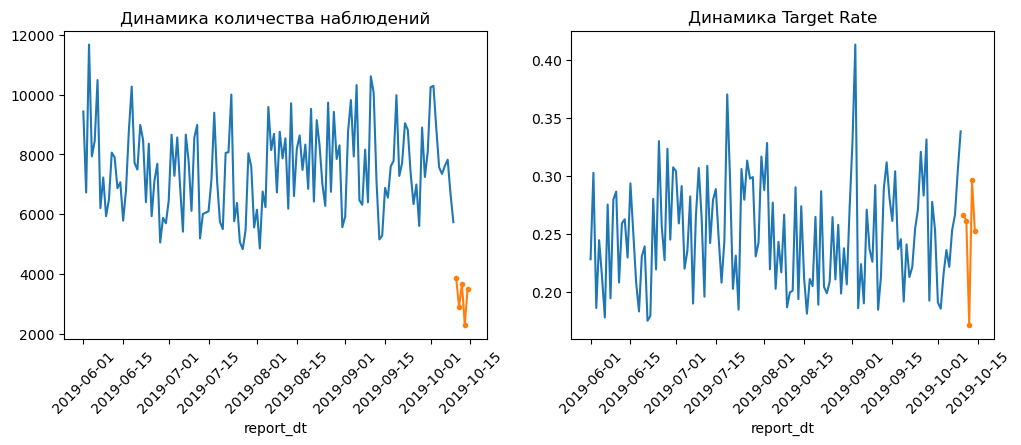

In [6]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title('Динамика количества наблюдений')
train.groupby('report_dt').size().plot(label = 'train')
val.groupby('report_dt').size().plot(label = 'val', marker='o', markersize=3)
plt.xticks(rotation=45)
plt.subplot(122)
plt.title('Динамика Target Rate')
train.groupby('report_dt').is_bad.mean().plot(label = 'train')
val.groupby('report_dt').is_bad.mean().plot(label = 'val', marker='o', markersize=3)
plt.xticks(rotation=45)
plt.show()

In [7]:
pd.concat([train.city.value_counts(1), train.groupby('city').is_bad.mean()], axis=1).head(10)

,city,is_bad
Москва,0.161006,0.161746
Санкт-Петербург,0.080526,0.135916
Краснодар,0.023991,0.175748
Казань,0.020479,0.139973
Екатеринбург,0.019433,0.148024
Новосибирск,0.018616,0.197796
Нижний Новгород,0.017782,0.152062
Ростов-на-Дону,0.015516,0.182782
Уфа,0.015370,0.156952
Челябинск,0.014783,0.171843


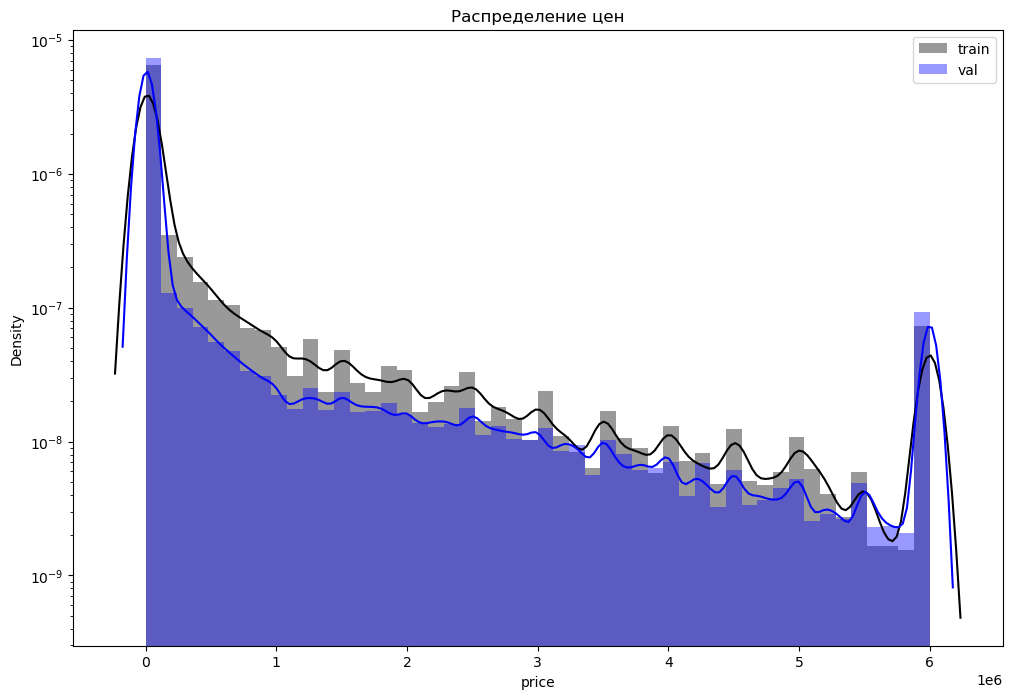

In [8]:
plt.figure(figsize=(12,8))
plt.title('Распределение цен')
sns.distplot(train[train.is_bad == 1].price.clip(0, train.price.quantile(0.99)), bins=50, color='black', label='train')
sns.distplot(train[train.is_bad == 0].price.clip(0, train.price.quantile(0.99)), bins=50, color='blue', label='val')
plt.legend()
plt.yscale('log')
plt.show()

In [9]:
pd.concat([train.groupby('category').price.mean(), train.groupby('category').is_bad.mean()], axis=1).\
                                    sort_values(by='price', ascending=False)

,price,is_bad
category,,
Животные,1.038066e+08,0.546100
Услуги,6.444688e+07,0.501579
Хобби и отдых,1.660304e+07,0.162921
Для дома и дачи,1.346817e+07,0.227725
Недвижимость,1.333033e+07,0.364042
Работа,9.279238e+06,0.394536
Личные вещи,6.101251e+06,0.137783
Транспорт,2.861547e+06,0.261986
Для бизнеса,2.429940e+06,0.146262


# Boosting

Помимо информации о тексте можно и нужно использовать некоторую информацию о типе объявления, категории, цене, городе и т.д. Как итог, получилось увеличить ключевую метрику на независимой выборке _val.csv_ на 0.5%.

In [16]:
train = pd.read_csv('../../data_dev/train_preproc.csv',lineterminator='\n')
val = pd.read_csv('../../data_dev/val_preproc.csv',lineterminator='\n')

train['normalized_text'] = train['normalized_text'].fillna('')
val['normalized_text'] = val['normalized_text'].fillna('')

In [18]:
from sklearn.model_selection import train_test_split
train, train_val = train_test_split(train, test_size=0.2, random_state=42)

In [19]:
short_list = ['subcategory', 'category', 'price', 'city', 'count_tokens']
cat_list = ['subcategory', 'category', 'city']

Был написан класс-обертка который состоит из четырех этапов:
1. Преобразование tf-idf
2. Классификатор над tf-idf текстами
3. Классификатор над мета-признаками (опционально)
4. Логрег над двумя скорами (опционально)

In [20]:
from custom.predict import ModelBoosting
model = ModelBoosting(clf_params = {'n_estimators': 5000, 'random_state': 42},
                      tfidf_params = {'max_features': 2000},
                      add_clf_params = {'n_estimators': 5000, 'random_state': 42},
                      add_clf_features = short_list, add_clf_cat_features = cat_list)


In [21]:
model.fit(train, train_val)

Fitting tf-idf model...


Fitting model on tf-idf features...
[250]	valid_0's auc: 0.963624	valid_0's binary_logloss: 0.176687
[500]	valid_0's auc: 0.96633	valid_0's binary_logloss: 0.16974
[750]	valid_0's auc: 0.967646	valid_0's binary_logloss: 0.166165
[1000]	valid_0's auc: 0.968473	valid_0's binary_logloss: 0.163689
[1250]	valid_0's auc: 0.969099	valid_0's binary_logloss: 0.161982
[1500]	valid_0's auc: 0.969543	valid_0's binary_logloss: 0.160603
[1750]	valid_0's auc: 0.969896	valid_0's binary_logloss: 0.159566
[2000]	valid_0's auc: 0.970163	valid_0's binary_logloss: 0.15869
[2250]	valid_0's auc: 0.970347	valid_0's binary_logloss: 0.157972
[2500]	valid_0's auc: 0.97052	valid_0's binary_logloss: 0.1573
[2750]	valid_0's auc: 0.970625	valid_0's binary_logloss: 0.156864
[3000]	valid_0's auc: 0.970774	valid_0's binary_logloss: 0.156408
[3250]	valid_0's auc: 0.970906	valid_0's binary_logloss: 0.156118


Fitting model on meta features...
[250]	valid_0's auc: 0.819539	valid_0's binary_loglos

In [22]:
from sklearn.metrics import roc_auc_score

(roc_auc_score(train.is_bad, model.predict_proba(train).T[1]),
 roc_auc_score(train_val.is_bad, model.predict_proba(train_val).T[1]),
 roc_auc_score(val.is_bad, model.predict_proba(val).T[1]))

(0.9930272590087443, 0.9711332698279551, 0.9643213882128099)

In [23]:
model.lr_stacking.coef_ # 1 - meta features, 2 - tfidf features

array([[2.71967941, 9.35466713]])

In [24]:
pd.Series(dict(zip(model.tfidf.get_feature_names(), model.clf.feature_importances_))).sort_values(ascending=False).head(20)

9_digits_10    1241
звонить        1044
8_digits_11    1010
состояние       843
телефон         798
размер          762
новый           702
номер           664
тело            559
продать         558
цена            556
ru              542
3_digits_1      502
работа          422
писать          402
9_digits_3      400
хороший         399
сайт            393
наличие         388
продавать       383
dtype: int32

In [25]:
pd.Series(dict(zip(short_list, model.add_clf.feature_importances_))).sort_values(ascending=False)

city            6508
price           3520
count_tokens    3266
subcategory     2758
category          58
dtype: int32

In [26]:
model.save_model('model.pkl')